In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.ticker as mtick
from matplotlib import pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score

In [2]:
pickle_off = open ("return_1d.pkl", "rb")
return_1d = pickle.load(pickle_off)
return_1d

,Nifty_50_1d_return,Dow_Jons_1d_return,SPX_500_1d_return,NASDAQ_1d_return,BRENT_1d_return,BOND_10Y_1d_return,Gold_1d_return,Inr_Usd_1d_return,Dollar_Index_1d_return,Bank_Nifty_1d_return,Nifty_IT_1d_return,Nifty_Auto_1d_return,Nifty_Metal_1d_return,Nifty_FMGC_1d_return,Nifty_Energy_1d_return,NIFTY_FIN_SERVICE_1d_return,Nifty_Infra_1d_return,Nifty_CMDT_1d_return,Nifty_Consumer_1d_return
Date,,,,,,,,,,,,,,,,,,,
08-09-11,-0.53,-1.42,-1.37,-1.26,-1.42,-1.81,-1.74,-1.00,-2.71,-0.70,8.26,0.42,-1.46,-0.27,-0.34,-1.00,-0.83,-0.81,-1.19
13-09-11,-0.95,-0.36,0.31,0.35,-0.30,1.97,-1.37,0.01,-2.73,-0.80,-1.27,1.72,0.03,-0.86,-1.16,0.42,-0.88,-0.26,0.88
14-09-11,-13.25,2.14,0.48,0.07,-2.42,-0.68,-1.19,-0.43,-0.88,-3.40,3.66,-0.71,-1.07,-91.91,3.21,-0.79,0.02,-1.14,-0.63
15-09-11,-0.13,0.31,0.28,-0.16,4.74,2.96,12.66,-0.67,6.38,0.40,-0.46,-5.15,8.29,-1.20,-0.03,-2.90,-2.51,5.99,-3.54
16-09-11,-0.87,-0.60,-0.67,-0.56,-2.03,-1.12,-1.77,-1.60,-1.58,-0.69,-1.44,-0.69,-0.91,3.86,-0.64,1.62,0.43,-0.60,-1.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24-04-23,-299.38,1.97,-0.06,-3.73,0.90,-3.49,-1.35,-0.55,22.50,-4.43,0.03,-0.96,-1.33,-0.35,108.75,-7.56,-2.08,-1.79,3.18
25-04-23,-0.78,-6.18,-19.57,5.77,-2.81,1.43,-0.49,1.22,-2.09,-0.92,-1.14,-3.07,0.37,-0.60,7.12,-1.13,0.35,-0.27,0.05
26-04-23,0.71,-0.33,-0.76,-1.24,0.61,-1.26,-2.69,-1.70,-1.76,2.54,-3.85,5.08,-1.71,2.08,-1.11,-2.33,-0.39,-1.47,0.29


In [3]:
# Add lagged returns as features
return_1d['Nifty_Metal_1d_return_lag1'] = return_1d['Nifty_Metal_1d_return'].shift(1)
return_1d['Nifty_50_1d_return_lag1'] = return_1d['Nifty_50_1d_return'].shift(1)
return_1d = return_1d.dropna()
return_1d['return_squared'] = return_1d['Nifty_Metal_1d_return'] ** 2
return_1d['return_lag_interaction'] = return_1d['Nifty_Metal_1d_return'] * return_1d['Nifty_50_1d_return_lag1']
# Detect and remove outliers using IQR
q1 = return_1d['Nifty_Metal_1d_return'].quantile(0.25)
q3 = return_1d['Nifty_Metal_1d_return'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr
return_1d = return_1d[(return_1d['Nifty_Metal_1d_return'] >= lower_bound) & (return_1d['Nifty_Metal_1d_return'] <= upper_bound)]
np.random.seed(42)

C:\Users\Harsh\AppData\Local\Temp\ipykernel_9088\1442012717.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_1d['return_squared'] = return_1d['Nifty_Metal_1d_return'] ** 2
C:\Users\Harsh\AppData\Local\Temp\ipykernel_9088\1442012717.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_1d['return_lag_interaction'] = return_1d['Nifty_Metal_1d_return'] * return_1d['Nifty_50_1d_return_lag1']


In [4]:
# Display the cleaned data
print("Cleaned data:")
print(return_1d.head().to_string(index=False))

Cleaned data:
 Nifty_50_1d_return  Dow_Jons_1d_return  SPX_500_1d_return  NASDAQ_1d_return  BRENT_1d_return  BOND_10Y_1d_return  Gold_1d_return  Inr_Usd_1d_return  Dollar_Index_1d_return  Bank_Nifty_1d_return  Nifty_IT_1d_return  Nifty_Auto_1d_return  Nifty_Metal_1d_return  Nifty_FMGC_1d_return  Nifty_Energy_1d_return  NIFTY_FIN_SERVICE_1d_return  Nifty_Infra_1d_return  Nifty_CMDT_1d_return  Nifty_Consumer_1d_return  Nifty_Metal_1d_return_lag1  Nifty_50_1d_return_lag1  return_squared  return_lag_interaction
              -0.95               -0.36               0.31              0.35            -0.30                1.97           -1.37               0.01                   -2.73                 -0.80               -1.27                  1.72                   0.03                 -0.86                   -1.16                         0.42                  -0.88                 -0.26                      0.88                       -1.46                    -0.53          0.0009             

In [5]:
# Display the statistics of the cleaned data
print("Statistics of the cleaned data:")
print(return_1d.describe())

Statistics of the cleaned data:
       Nifty_50_1d_return  Dow_Jons_1d_return  SPX_500_1d_return  \
count         1783.000000         1783.000000        1783.000000   
mean            -0.526854           -4.603068          -0.090415   
std             28.018960          110.097916          39.637619   
min           -448.890000        -3606.010000        -363.000000   
25%             -1.765000           -1.900000          -2.000000   
50%             -0.900000           -1.000000          -1.000000   
75%             -0.030000           -0.110000          -0.150000   
max            904.410000          354.210000        1128.740000   

       NASDAQ_1d_return  BRENT_1d_return  BOND_10Y_1d_return  Gold_1d_return  \
count       1783.000000      1783.000000         1783.000000     1783.000000   
mean          -2.875132        -2.198368           -1.024414       -0.731296   
std           64.398007        22.878471            2.340726       12.011770   
min        -1517.720000      -426.1

In [6]:
# Correlation analysis
corr_matrix_1d = return_1d.corr()
nifty_corr_1d = pd.DataFrame(return_1d.corr()['Nifty_Metal_1d_return'].sort_values())
nifty_corr_1d

,Nifty_Metal_1d_return
return_squared,-0.595605
return_lag_interaction,-0.043913
Nifty_CMDT_1d_return,-0.032660
Nifty_Metal_1d_return_lag1,-0.032343
Gold_1d_return,-0.031672
Dollar_Index_1d_return,-0.026085
Dow_Jons_1d_return,-0.025753
SPX_500_1d_return,-0.022766
Inr_Usd_1d_return,-0.022641
Nifty_FMGC_1d_return,-0.013914


<Axes: >

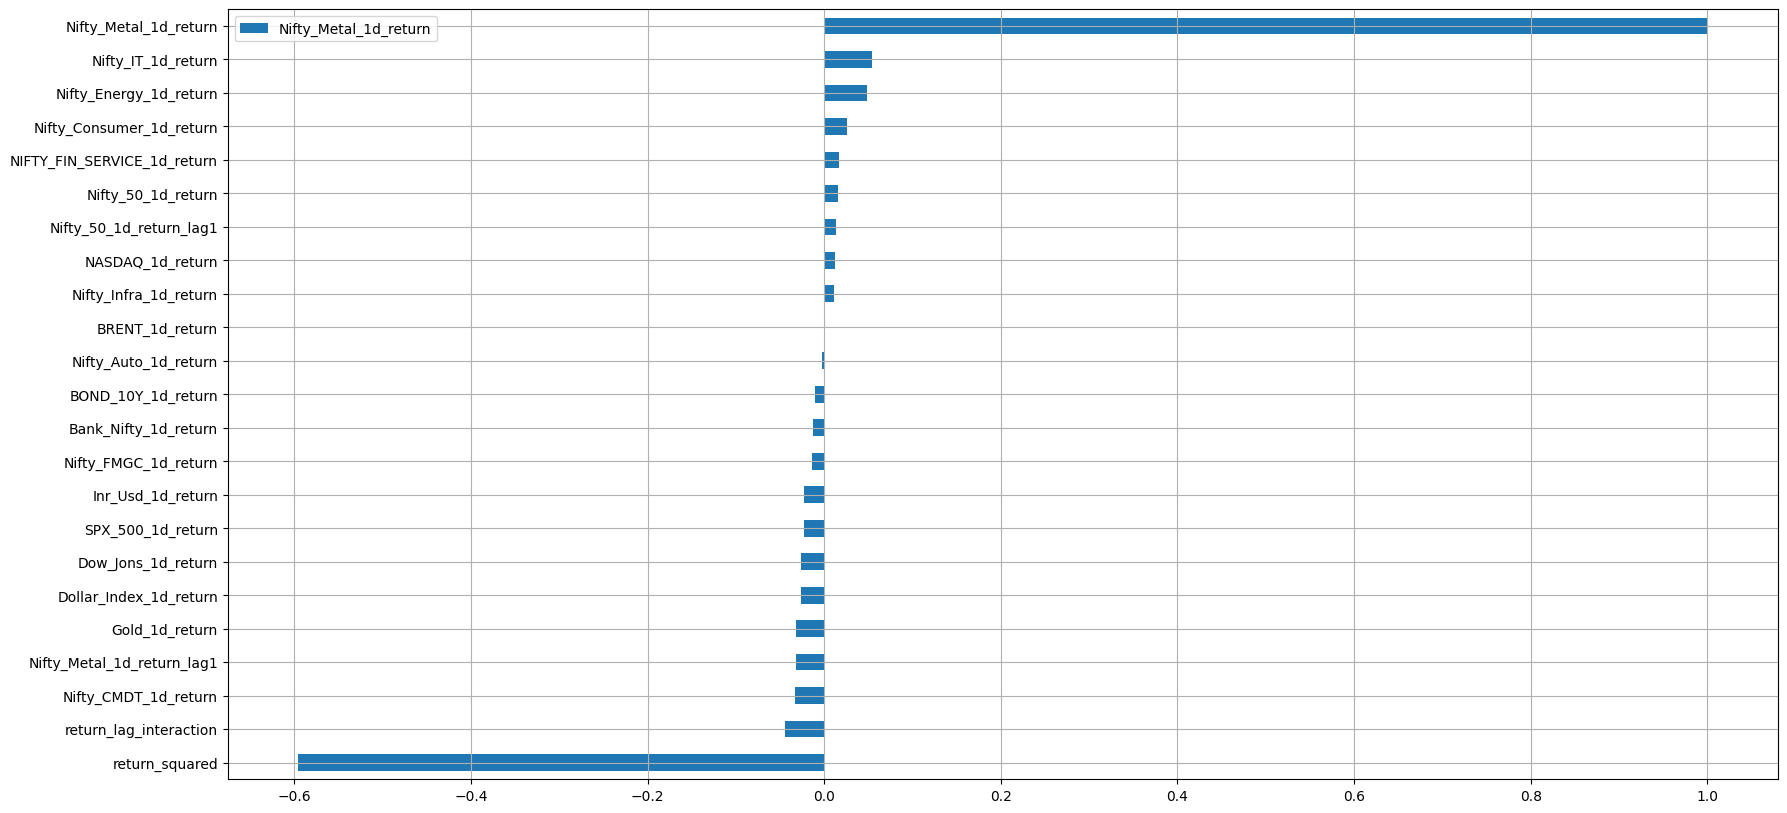

In [7]:
filter = np.abs(nifty_corr_1d)  # this creates a float64 array
mask = filter >= -1  # this creates a boolean mask based on the condition
nifty_corr_1d[mask].plot.barh(figsize=(20,10), grid=True)  # use the boolean mask to index the DataFrame

In [8]:
# Feature selection using mutual information
selector = SelectKBest(score_func=mutual_info_regression, k='all')
X = return_1d.drop(columns='Nifty_Metal_1d_return')
y = return_1d['Nifty_Metal_1d_return']
X_new = selector.fit_transform(X, y)
print('Selected features:', X.columns[selector.get_support()])

Selected features: Index(['Nifty_50_1d_return', 'Dow_Jons_1d_return', 'SPX_500_1d_return',
       'NASDAQ_1d_return', 'BRENT_1d_return', 'BOND_10Y_1d_return',
       'Gold_1d_return', 'Inr_Usd_1d_return', 'Dollar_Index_1d_return',
       'Bank_Nifty_1d_return', 'Nifty_IT_1d_return', 'Nifty_Auto_1d_return',
       'Nifty_FMGC_1d_return', 'Nifty_Energy_1d_return',
       'NIFTY_FIN_SERVICE_1d_return', 'Nifty_Infra_1d_return',
       'Nifty_CMDT_1d_return', 'Nifty_Consumer_1d_return',
       'Nifty_Metal_1d_return_lag1', 'Nifty_50_1d_return_lag1',
       'return_squared', 'return_lag_interaction'],
      dtype='object')


In [9]:
# Feature Scaling
scaler = StandardScaler()
X = return_1d.drop(columns='Nifty_Metal_1d_return')
y = return_1d['Nifty_Metal_1d_return']
X = scaler.fit_transform(X_new)
y = y.astype('float32')
print(X[-5:])
print(y[-5:])

[[-1.06690965e+01  5.97187682e-02  7.67542656e-04 -1.32784860e-02
   1.35465220e-01 -1.05363812e+00 -5.15226321e-02  4.94197438e-02
   2.81410709e+00 -3.28234974e-01  1.98261990e-02 -1.92158168e-02
  -2.24499471e-02  4.90759688e+00 -1.44415826e-01 -7.02705123e-02
  -4.45358825e-02  1.65244191e-01  8.08539304e-02  1.31879647e-02
  -2.60523705e-01 -1.92969072e-02]
 [-9.03735906e-03 -1.43270154e-02 -4.91579721e-01  1.34282994e-01
  -2.67414577e-02  1.04886382e+00  2.00938966e-02  3.62173942e-01
  -1.06076867e-01 -2.46440003e-02 -4.97970744e-03 -6.40794745e-02
  -2.38077522e-02  3.71950400e-01 -2.56816575e-02  4.12669065e-02
  -1.96336521e-02  2.76586651e-02 -2.57914507e-02 -4.15734537e+00
  -6.56735942e-01 -1.25658483e+00]
 [ 4.41558364e-02  3.88224121e-02 -1.68974027e-02  2.53981546e-02
   1.22785992e-01 -1.00674840e-01 -1.63111177e-01 -1.53782137e-01
  -6.68877371e-02  2.74622315e-01 -6.24361231e-02  1.09209061e-01
  -9.25208208e-03  4.65363202e-03 -4.78404447e-02  7.30077896e-03
  -3.9

Data Cleaning And Transformation Completed

Model Building for Features Importance

In [10]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Define regression models
dtr = DecisionTreeRegressor(max_depth=5)
rfr = RandomForestRegressor(n_estimators=50, random_state=2)
etr = ExtraTreesRegressor(n_estimators=50, random_state=2)
gbr = GradientBoostingRegressor(n_estimators=50, random_state=2)
xgbr = XGBRegressor(n_estimators=50, random_state=2)

In [12]:
regressors = {
    'DTR': dtr,
    'RFR': rfr,
    'ETR': etr,
    'GBR': gbr,
    'XGBR': xgbr
}

In [13]:
def train_regressor(regressor, X_train, y_train, X_test, y_test):
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

In [14]:
mse_scores = []
r2_scores = []
for name, regressor in regressors.items():
    current_mse, current_r2 = train_regressor(regressor, X_train, y_train, X_test, y_test)
    print(f"For {name}:")
    print(f"MSE: {current_mse:.4f}")
    print(f"R2: {current_r2:.4f}\n")
    mse_scores.append(current_mse)
    r2_scores.append(current_r2)

For DTR:
MSE: 0.4107
R2: 0.7800

For RFR:
MSE: 0.3161
R2: 0.8307

For ETR:
MSE: 0.6236
R2: 0.6660

For GBR:
MSE: 0.1349
R2: 0.9277

For XGBR:
MSE: 0.0884
R2: 0.9527



In [15]:
scaler = StandardScaler()
# Find the index of the model with the lowest MSE score
best_model_index = np.argmin(mse_scores)
# Get the name of the best model
best_model_name = list(regressors.keys())[best_model_index]
# Print the name of the best model
print(f"The best model is {best_model_name} with an MSE of {mse_scores[best_model_index]:.4f}.")
# Train the best model on the full dataset
best_model = regressors[best_model_name]
best_model.fit(scaler.fit_transform(X), y)

The best model is XGBR with an MSE of 0.0884.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=2, ...)

The best model is XGBR with an MSE of 0.0884.

In [16]:
y_pred = etr.predict(X_test)
df_1d = pd.DataFrame({'Actual': y_test, 'Predicted':y_pred})
df_1d

,Actual,Predicted
Date,,
20-09-17,-0.90,-0.7864
10-08-21,0.48,-0.0390
01-02-13,-3.60,-3.4578
28-07-17,0.33,-0.0048
12-06-17,-1.23,-1.2366
...,...,...
08-09-17,-0.84,-0.6354
18-11-14,-3.19,-2.3062
16-12-13,-1.16,-0.5492


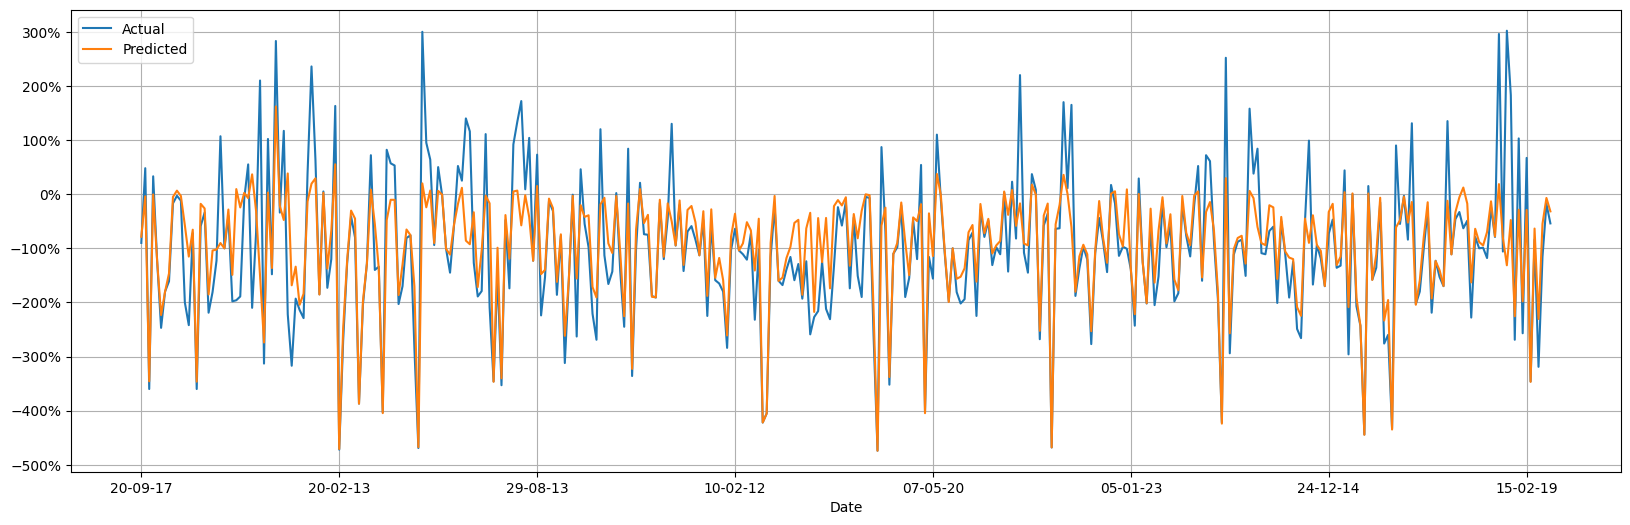

In [17]:
ax = df_1d.plot(figsize=(20,6), grid=True)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

C:\Users\Harsh\AppData\Local\Temp\ipykernel_9088\3094767840.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test-y_pred)


<Axes: xlabel='Nifty_Metal_1d_return', ylabel='Density'>

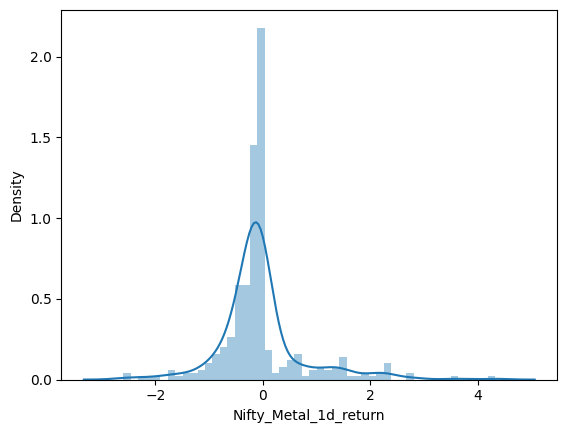

In [18]:
sns.distplot(y_test-y_pred)

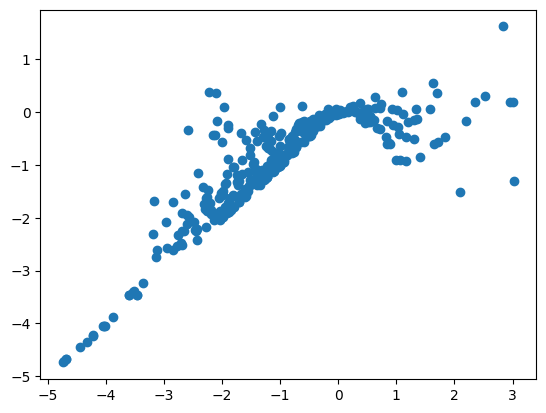

In [19]:
plt.scatter(y_test,y_pred)
